v1.0

The objective of this notebook is to:
- evaluate the model's sensitivity regarding **n_estimators**

# Pre-checks

In [ ]:
## Check for Google Drive Connectivity
try:
    from google.colab import drive
    drive.mount('/content/drive')
    google_env = True
except:
    print("Not a Goolge Drive Environment.")
    google_env = False

Not a Goolge Drive Environment.


In [ ]:
import time
t_start = time.time()

In [ ]:
# Use parameters to enable/disable the fastrun

FASTRUN = False
#FASTRUN = True

# Size of the fastrun dataframe
sample_fraction = 0.005
print("==="*40)
print("Fastrun enabled:", FASTRUN)
if FASTRUN: print("Sample size:",sample_fraction)
print("==="*40)


Fastrun enabled: False


# Setup Environment

## Install Modules

In [ ]:
#!pip install watermark
#!pip install icecream

## Import Modules

In [ ]:
# Base libraries
import os
from datetime import date

# Scientific libraries
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=0.8)

# Helper libraries
from watermark import watermark
from icecream import ic
import gc # garbage collection to optimize memory usage: use "gc.collect()"
import warnings
warnings.filterwarnings('ignore')

# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark

## Global Parameters

In [ ]:
seed = 42
cpu_count = os.cpu_count()
cpu_count = cpu_count-2  # to keep machine responsive when fitting the models
notebook_no = "08.01"
today = date.today()

## Global Helper Functions

In [ ]:
import http.client
import urllib


def send_push(message):
    """Send push notifications to pushover service."""
    try:
        conn = http.client.HTTPSConnection("api.pushover.net:443")
        conn.request("POST", "/1/messages.json",
                     urllib.parse.urlencode({
                         "token": "ahs1q4mwpnxe3645zeaqzas69whq7a",  # ML Notifications Channel
                         "user": "u5vr1qkc9ghudg2ehuug153okeiz1d",
                         "message": message,
                     }), {"Content-type": "application/x-www-form-urlencoded"})

        conn.getresponse()

    except:
        print("There was a communication issue (pushover).")


In [ ]:
def fast_run_sampling(df, sample_fraction):
    """Return a fraction of the dataset."""
    print("Labels before sampling:\n", df['label'].value_counts())
    df = df.groupby('label').sample(frac=sample_fraction, random_state=seed) 
    #df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
    print("Labels after sampling:\n", df['label'].value_counts())
    return df
    

In [ ]:
def calculate_duration(t_start, t_end):
    """Return run time in minutes."""
    total_runtime = t_end-t_start
    total_runtime_min = round((total_runtime/60), 2)
    print(str(total_runtime_min)+" minutes")

    return total_runtime_min


# 3.0 Load Data

In [ ]:
# Load Data
if google_env:
    # Location for "shared with" people
    # create a shortcut of the shared folder in your Google Drive root folder
    ROOT_PATH = "/content/drive/MyDrive/SIADS696/Environment/"
else:
    ROOT_PATH = "../"
    print("Not a Google Drive Environment. Loading local files.")

PATH_DATA = "data/"
PATH_DATA_RAW = "data/raw/"
PATH_DATA_INT = "data/interim/"
PATH_DATA_PRO = "data/processed/"
PATH_DATA_MOD = "models/"
PATH_DATA_REP = "reports/"
PATH_DATA_FIG = "reports/figures/"
PATH_DATA_HTML = "reports/html/"

# Dictionary to store file names and their corresponding dataframes
files = {
    "train_features_clean_stats.parquet.gzip": "df_wiki_train_stats",
    "test_features_clean_stats.parquet.gzip": "df_wiki_test_stats",
    "train_features_rs.parquet.gzip": "df_wiki_train_rs",
    "test_features_rs.parquet.gzip": "df_wiki_test_rs",
    "train_features_nltk.parquet.gzip": "df_wiki_train_nltk",
    "test_features_nltk.parquet.gzip": "df_wiki_test_nltk",
    "train_features_aoa.parquet.gzip": "df_wiki_train_aoa",
    "test_features_aoa.parquet.gzip": "df_wiki_test_aoa",
    "train_features_crb.parquet.gzip": "df_wiki_train_crb",
    "test_features_crb.parquet.gzip": "df_wiki_test_crb",
    "train_features_w2v.parquet.gzip": "df_wiki_train_w2v",
    "test_features_w2v.parquet.gzip": "df_wiki_test_w2v",
   # "train_mNB_predict.parquet.gzip": "df_wiki_train_MNB",  # data leakage risk
   # "test_mNB_predict.parquet.gzip": "df_wiki_test_MNB",    # data leakage risk
}

# Load data into corresponding dataframes
for file, df_name in files.items():
    if df_name not in globals():
        globals()[df_name] = pd.read_parquet(ROOT_PATH + PATH_DATA_INT + file)


Not a Google Drive Environment. Loading local files.


In [ ]:
# Combine dataframes into one
df_train = pd.DataFrame()
df_train = pd.concat([df_train, df_wiki_train_stats], axis=1)
df_train = pd.concat([df_train, df_wiki_train_rs], axis=1)
df_train = pd.concat([df_train, df_wiki_train_nltk], axis=1)
df_train = pd.concat([df_train, df_wiki_train_aoa], axis=1)
df_train = pd.concat([df_train, df_wiki_train_crb], axis=1)
df_train = pd.concat([df_train, df_wiki_train_w2v], axis=1)

if FASTRUN:
    df_train = fast_run_sampling(df_train, sample_fraction)


In [ ]:
df_train.shape

(416768, 155)

In [ ]:
df_rfecv_selected_feature = pd.read_csv(ROOT_PATH+PATH_DATA_INT+"RFECV10-RF-selected_features-table_04.02.csv")
rfecv_selected_feature = sorted(df_rfecv_selected_feature['Selected Features'].to_list())
ic(len(rfecv_selected_feature));


ic| len(rfecv_selected_feature): 125


# Sensitivity Analysis

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from scipy.stats import randint

In [ ]:
k=10
skfold = StratifiedKFold(n_splits=k)
scaler = MinMaxScaler((0, 1))
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)

n_iter = 25


In [ ]:
X = df_train[rfecv_selected_feature].copy()
y = df_train["label"]

ic(X.shape);
ic(y.shape);


ic| X.shape: (416768, 125)
ic| y.shape: (416768,)


In [ ]:
pipeline = Pipeline([('scaler', scaler), ('estimator', rf)])

In [ ]:
# Define the hyperparameter search space
param_dist = {'estimator__n_estimators': randint(5, 600),
             # 'estimator__max_features': ['sqrt', 'log2', None],
             # 'estimator__max_depth': [None, 5, 10, 15, 20, 25],
             # 'estimator__min_samples_split': randint(2, 10),
             # 'estimator__min_samples_leaf': randint(1, 10)
             }

# Perform the hyperparameter search
search = RandomizedSearchCV(estimator=pipeline,
                            param_distributions=param_dist,
                            n_iter=n_iter,
                            scoring='accuracy',
                            cv=skfold,
                            n_jobs=-1,
                            random_state=seed)

search.fit(X, y)

# Print the best hyperparameters
print("Best hyperparameters: ", search.best_params_)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('estimator',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002886A4B18A0>},
                   random_state=42, scoring='accuracy')

Best hyperparameters:  {'estimator__n_estimators': 418}


In [ ]:
search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator__n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
# Extract the mean test scores and standard deviations for each set of hyperparameters
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']

# Extract the values of the n_estimators hyperparameter for each set of hyperparameters
n_estimators = search.cv_results_['param_estimator__n_estimators'].data

In [ ]:
# Create DataFrame
result_df = pd.DataFrame(
    {
    'n_estimators': n_estimators,
    'Accuracy': means, 
    'STD': stds,
    }
)

result_df.sort_values("n_estimators", inplace=True)

result_df['lower_band'] = result_df['Accuracy'] - result_df['STD']
result_df['upper_band'] = result_df['Accuracy'] + result_df['STD']

result_df

,n_estimators,Accuracy,STD,lower_band,upper_band
5,25,0.737943,0.001577,0.736365,0.739520
4,76,0.747901,0.000819,0.747081,0.748720
11,92,0.748870,0.001139,0.747731,0.750009
13,104,0.749391,0.001004,0.748387,0.750394
0,107,0.749573,0.001035,0.748537,0.750608
3,111,0.749664,0.001028,0.748636,0.750692
6,126,0.750338,0.001208,0.749131,0.751546
14,135,0.750657,0.001165,0.749493,0.751822
22,165,0.751070,0.001187,0.749883,0.752257
20,196,0.751596,0.001387,0.750208,0.752983


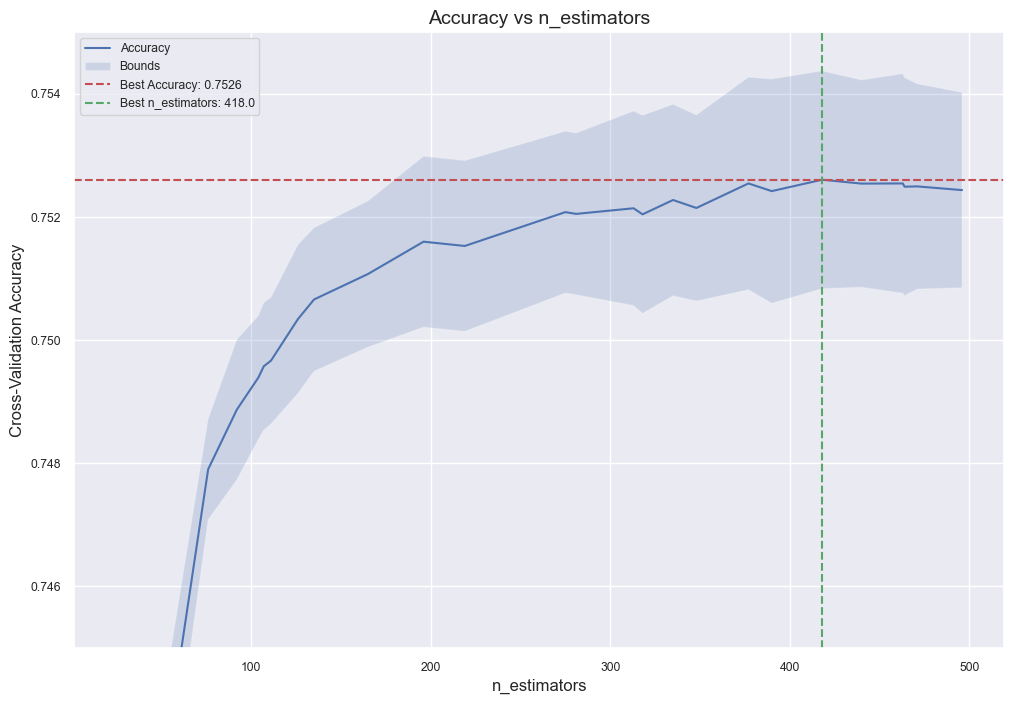

In [ ]:
import matplotlib.pyplot as plt

result_df = result_df.replace([np.inf, -np.inf], np.nan)

# Determine the value of the best n_estimators and corresponding accuracy
best_n_estimators = result_df.loc[result_df['Accuracy'].idxmax()]['n_estimators']
best_accuracy = result_df.loc[result_df['Accuracy'].idxmax()]['Accuracy']

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the mean test score
ax.plot(result_df['n_estimators'], result_df['Accuracy'], label='Accuracy')

# Add the lower and upper bounds
ax.fill_between(result_df['n_estimators'], result_df['lower_band'], result_df['upper_band'], alpha=0.2, label='Bounds')

# Add a horizontal line for the best accuracy
ax.axhline(y=best_accuracy, color='r', linestyle='--', label='Best Accuracy')

# Add a vertical line for the best n_estimators
ax.axvline(x=best_n_estimators, color='g', linestyle='--', label='Best n_estimators')

# Set the x and y axis labels
ax.set_xlabel('n_estimators', fontsize=12)
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12)

# set the y-axis range to be shorter
plt.ylim(0.745, 0.755)

# Add a title
ax.set_title('Accuracy vs n_estimators', fontsize=14)

# Add a legend with best values
ax.legend(['Accuracy', 'Bounds', f'Best Accuracy: {best_accuracy:.4f}', f'Best n_estimators: {best_n_estimators}'])

# Display the plot
plt.show();


In [ ]:
t_end = time.time()
calculate_duration(t_start, t_end);


468.25 minutes


# Export

In [ ]:
# Save the figure
if not FASTRUN:
     fig.savefig(ROOT_PATH+PATH_DATA_FIG+f'{today}_sensitivity-analysis_RF_n_estimators_chart_07.05.png');


In [ ]:
if not FASTRUN:
    result_df.to_csv(ROOT_PATH+PATH_DATA_REP+f'{today}_sensitivity-analysis_RF_n_estimators_table_07.05.csv', index=False);


# Watermark

In [ ]:
%watermark

Last updated: 2023-02-25T08:02:50.369313+01:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 13, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [ ]:
%watermark --iversions

pandas    : 1.5.3
numpy     : 1.24.1
seaborn   : 0.12.2
matplotlib: 3.6.3



-----


In [ ]:
output_file = f'{ROOT_PATH}{PATH_DATA_HTML}{today}_07.05_sensitivity_analysis_RF-n_estimators.html'
!jupyter nbconvert --to html "07.05_sensitivity_analysis_RF-n_estimators.ipynb" --output {output_file}

[NbConvertApp] Converting notebook 08.01_sensitivity_analysis_RF-n_estimators_GC.ipynb to html
[NbConvertApp] Writing 733341 bytes to ..\reports\html\2023-02-25_08.01_sensitivity_analysis_RF-n_estimators_GC.html
